# Soft Actor-Critic (SAC) Homework

Soft Actor-Critic (SAC) is an off-policy, maximum entropy algorithm used in Deep Reinforcement Learning. It follows the principles of policy iteration and consists of two main steps:

1. **Policy Evaluation**: Learning the soft Q-values under the current policy. This is done by performing a SARSA-like temporal difference update on the critic.
2. **Policy Improvement**: Improving the policy based on the soft Q-values. This involves backpropagating through the critic to change the policy such that the critic's output is maximized.

Despite being developed a few years ago, SAC remains an effective algorithm, especially when using a high Replay Ratio (RR), which is the number of gradient update steps per environment step. However, increasing RR can lead to training instability, negatively affecting the training process.

## Homework Tasks

In this homework, you will address the issue of value overestimation associated with temporal difference learning, which is particularly noticeable in high RR settings. Your tasks are:

1. **Fill-in the implementation of the SAC Algorithm**
   - Develop the code for the policy evaluation and policy improvement steps of the SAC algorithm.
   - Implement a simple remedy to mitigate training instabilities.

2. **Train SAC Agent on the Ant Environment**
   - Use the Ant environment to train your SAC agent and observe its performance.

3. **Investigate Training Instabilities in High RR**
   - Analyze the training instabilities that arise when using a high Replay Ratio.

## References

1. Haarnoja, T., et al. (2018). "Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." [arXiv:1812.05905](https://arxiv.org/abs/1812.05905)
2. [OpenReview: Replay Ratio in Off-Policy Algorithms](https://openreview.net/pdf?id=OpC-9aBBVJe)
3. Fujimoto, S., et al. (2018). "Addressing Function Approximation Error in Actor-Critic Methods." [arXiv:1802.09477](https://arxiv.org/abs/1802.09477)
4. [Training Instabilities in High Replay Ratio](https://arxiv.org/pdf/2403.05996)


Ensure your implementation is clear and well-documented, and analyze the results thoroughly. Make sure you use gpu runtime to speed up computations.

## Provided code

In [3]:
!pip install gymnasium[mujoco]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 27.1 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import numpy as np
import random
import os
import copy
from typing import OrderedDict
import gymnasium as gym
from google.colab import files

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class ReplayBuffer:
    def __init__(self, env, capacity: int):
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.states = np.empty((capacity, state_dim), dtype=np.float32)
        self.actions = np.empty((capacity, action_dim), dtype=np.float32)
        self.rewards = np.empty((capacity, 1), dtype=np.float32)
        self.masks = np.empty((capacity, 1), dtype=np.float32)
        self.next_states = np.empty((capacity, state_dim), dtype=np.float32)
        self.size = 0
        self.insert_index = 0
        self.capacity = capacity

    def add(self, state: np.ndarray, action: np.ndarray, reward: float, next_state: np.ndarray, mask: float):
        self.states[self.insert_index] = state
        self.actions[self.insert_index] = action
        self.rewards[self.insert_index] = reward
        self.masks[self.insert_index] = mask
        self.next_states[self.insert_index] = next_state
        self.insert_index = (self.insert_index + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def to_torch(self, array):
        return torch.from_numpy(array).float()

    def sample(self, batch_size: int, num_batches: int):
        indxs = np.random.randint(self.size, size=(num_batches, batch_size))
        states = self.to_torch(self.states[indxs])
        actions = self.to_torch(self.actions[indxs])
        rewards = self.to_torch(self.rewards[indxs])
        next_states = self.to_torch(self.next_states[indxs])
        masks = self.to_torch(self.masks[indxs])
        return states, actions, rewards, next_states, masks

In [7]:
def set_seed(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

def get_masks(terminates, truncates):
    masks = 0.0
    if not terminates or truncates:
        masks = 1.0
    return masks

In [8]:
def weight_init(model):
    if isinstance(model, nn.Linear):
        nn.init.orthogonal_(model.weight.data)
        model.bias.data.fill_(0.0)

class Actor(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 256):
        super(Actor, self).__init__()
        self.log_std_min = -10.0
        self.log_std_max = 2.0
        self.activation = nn.ReLU()
        self.layers = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, 2 * action_dim))
        self.apply(weight_init)

    def forward(self, state):
        mu, log_std = self.layers(state).chunk(2, dim=-1)
        # cap log_std between log_std_min and log_std_max - good for stability
        log_std = self.log_std_min + 0.5 * (self.log_std_max - self.log_std_min) * (torch.tanh(log_std) + 1)
        return mu, log_std.exp()

# Task 1 - Fill-in the implementation of the SAC Algorithm

## Task 1a - Implement a simple remedy to mitigate training instabilities

Implement two versions of the critic network - with layer normalization and without.

Common elements of the architecture:
* Input: state and action
* Output: value of the action-state pair - float
* Depth: 2 hidden layers of size `hidden_dim`
* Activation: `self.activation`

Layer normalization should be applied after each hidden layer.


In [9]:
class Critic(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 256, use_layernorm: bool = False):
        super(Critic, self).__init__()
        self.activation = nn.ReLU()
        if use_layernorm:
            self.layers = nn.Sequential(
                nn.Linear(state_dim + action_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                self.activation,
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                self.activation,
                nn.Linear(hidden_dim, 1)
            )
        else:
            self.layers = nn.Sequential(
                nn.Linear(state_dim + action_dim, hidden_dim),
                self.activation,
                nn.Linear(hidden_dim, hidden_dim),
                self.activation,
                nn.Linear(hidden_dim, 1)
            )

        self.apply(weight_init)

    def forward(self, state, action):
        state_action = torch.concat((state, action), dim=1)
        q_value = self.layers(state_action)
        return q_value

class DoubleCritic(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 256, use_layernorm: bool = False):
        super(DoubleCritic, self).__init__()
        self.critic1 = Critic(state_dim=state_dim, action_dim=action_dim, hidden_dim=hidden_dim, use_layernorm=use_layernorm)
        self.critic2 = Critic(state_dim=state_dim, action_dim=action_dim, hidden_dim=hidden_dim, use_layernorm=use_layernorm)

    def forward(self, state, action):
        q1 = self.critic1(state, action)
        q2 = self.critic2(state, action)
        return q1, q2

## Task 1b - Implement Update Steps of the SAC Algorithm
Please fill missing parts of code in the following key sections of the SAC algorithm:
1. `target_Q` computation in method `update_critic` - compute q-backup according to equations 3, 5, and 6 from [1]. Remeber you are using double q-learning setup and max entropy setting.
2. `actor_loss` computation in method `update_actor` - compute actor loss according to equation 7 from [1]. Remeber you are using double q-learning setup.
3. `alpha_loss` computation in method `update_actor` - compute alpha loss according to equation 18 from [1].

**References**
 1. Haarnoja, T., et al. (2018). "Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." [arXiv:1812.05905](https://arxiv.org/abs/1812.05905)

In [10]:
def gaussian_logprob(noise, log_std):
    residual = (-0.5 * noise.pow(2) - log_std).sum(-1, keepdim=True)
    return residual - 0.5 * np.log(2 * np.pi) * noise.size(-1)

def squash(pi, log_prob):
    if pi is not None:
        pi = torch.tanh(pi)
    if log_prob is not None:
        log_prob -= torch.log(nn.functional.relu(1 - pi.pow(2)) + 1e-6).sum(-1, keepdim=True)
    return pi, log_prob

class SAC(nn.Module):
    def __init__(self, env, use_layernorm: bool = False):
        super(SAC, self).__init__()
        self.device = DEVICE
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.hidden_dim = 256
        self.learning_rate = 3e-3
        self.discount = 0.99
        self.target_entropy = -np.prod(self.action_dim) / 2
        self.tau = 0.005
        self.use_layernorm = use_layernorm
        self.reset()
        self.logger = {'q_value': [], 'temperature': [], 'entropy': [], 'critic_loss': [], 'actor_loss': [], 'returns': []}

    def reset(self):
        self.actor = Actor(self.state_dim, self.action_dim, self.hidden_dim).to(self.device)
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=self.learning_rate)
        self.critic = DoubleCritic(self.state_dim, self.action_dim, self.hidden_dim, self.use_layernorm).to(self.device)
        self.target_critic = copy.deepcopy(self.critic).to(self.device)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=self.learning_rate)
        self.log_alpha = torch.tensor(np.log(1.0)).to(self.device)
        self.log_alpha.requires_grad = True
        self.optimizer_log_alpha = torch.optim.Adam([self.log_alpha], lr=self.learning_rate, )

    @property
    def alpha(self):
        return self.log_alpha.exp()

    def get_action(self, state, return_logprob=False, temperature=1.0):
        mu, std = self.actor(state)
        noise = torch.randn_like(mu)
        std = std * temperature
        action = mu + noise * std
        if return_logprob:
            log_prob = gaussian_logprob(noise, std.log())
            action, log_prob = squash(action, log_prob)
            return action, log_prob
        else:
            action, _ = squash(action, None)
            return action

    def update(self, step, states, actions, rewards, next_states, masks):
        for i in range(states.shape[0]):
            self.update_critic(step, states[i], actions[i], rewards[i], next_states[i], masks[i])
            self.update_actor(step, states[i])
            self.update_target_critic(self.tau)

    def update_target_critic(self, tau):
        for param, target_param in zip(self.critic.parameters(), self.target_critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def update_critic(self, step, states, actions, rewards, next_states, masks):
        with torch.no_grad():
            next_actions, next_log_prob = self.get_action(next_states, return_logprob=True)
            target_Q1, target_Q2 = self.target_critic(next_states, next_actions)
            min_target_Q = torch.min(target_Q1, target_Q2)
            target_Q = rewards + masks * self.discount * (min_target_Q - self.alpha * next_log_prob)
        current_Q1, current_Q2 = self.critic(states, actions)
        critic_loss = nn.functional.mse_loss(current_Q1, target_Q) + nn.functional.mse_loss(current_Q2, target_Q)
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()
        if step == 1:
            self.logger['q_value'].append(current_Q1.mean().detach().item())
            self.logger['critic_loss'].append(critic_loss.mean().detach().item())

    def update_actor(self, step, states):
        actions, log_probs = self.get_action(states, return_logprob=True, temperature=1.0)
        q1, q2 = self.critic(states, actions)
        min_q = torch.min(q1, q2)
        actor_loss = (self.alpha * log_probs - min_q).mean()
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        self.optimizer_log_alpha.zero_grad()
        alpha_loss = -(self.alpha * (log_probs + self.target_entropy).detach()).mean()
        alpha_loss.backward()
        self.optimizer_log_alpha.step()
        if step == 1:
            entropy = log_probs.mean()
            self.logger['entropy'].append(entropy.detach().item())
            self.logger['temperature'].append(self.alpha.detach().item())
            self.logger['actor_loss'].append(actor_loss.detach().item())

# Task 2 - Train SAC Agent on the Ant Environment
Train the following models:

1. use_layernorm = False, replay_ratio = 1
2. use_layernorm = False, replay_ratio = 8
3. use_layernorm = True, replay_ratio = 8

In [11]:
def train(init_steps: int = 1000,
          training_steps: int = 50000,
          replay_ratio: int = 8,
          use_layernorm: bool = False):

    set_seed(0)
    env = gym.make('Ant-v4')

    agent = SAC(env, use_layernorm=use_layernorm).to(DEVICE)
    agent = torch.compile(agent)
    buffer = ReplayBuffer(env, training_steps)

    state, _ = env.reset(seed=np.random.randint(0,1e7))
    state = torch.from_numpy(state).float().to(DEVICE)

    returns = 0.0
    episode_step = 0

    for step in range(1, training_steps + 1):
        if step >= init_steps:
            action = agent.get_action(state).detach().cpu().numpy()
        else:
            action = env.action_space.sample()

        next_state, reward, terminal, truncate, _ = env.step(action)
        next_state = torch.from_numpy(next_state).float().to(DEVICE)

        mask = get_masks(terminal, truncate)

        returns += reward
        episode_step += 1

        buffer.add(state.cpu().numpy(), action, reward, next_state.cpu().numpy(), mask)

        if step >= init_steps:
            states, actions, rewards, next_states, masks = buffer.sample(256, replay_ratio)
            states = states.to(DEVICE)
            actions = actions.to(DEVICE)
            rewards = rewards.to(DEVICE)
            next_states = next_states.to(DEVICE)
            masks = masks.to(DEVICE)

            agent.update(episode_step, states, actions, rewards, next_states, masks)

        if terminal or truncate:
            state, _ = env.reset(seed=np.random.randint(0, 1e7))
            state = torch.from_numpy(state).float().to(DEVICE)

            if len(agent.logger['q_value']) > 0:
                agent.logger['returns'].append(returns)
                print(f"TrainStep: {step} Returns: {np.round(returns, 2)} Q-values: {np.round(agent.logger['q_value'][-1], 2)} Temperature: {np.round(agent.logger['temperature'][-1], 2)} Entropy: {np.round(agent.logger['entropy'][-1], 2)}")

            returns = 0.0
            episode_step = 0
        else:
            state = next_state

    return agent.logger

In [12]:
# train low rr agent ~ 10 min
history_lowrr = train(replay_ratio=1, use_layernorm=False)
np.savez("history_lowrr.npz", history_lowrr)
files.download("history_lowrr.npz")

TrainStep: 1346 Returns: -74.51 Q-values: 3.93 Temperature: 0.52 Entropy: -5.29
TrainStep: 1362 Returns: 0.6 Q-values: 4.11 Temperature: 0.42 Entropy: -5.26
TrainStep: 1471 Returns: -60.51 Q-values: 4.08 Temperature: 0.41 Entropy: -5.34
TrainStep: 2471 Returns: 16.98 Q-values: 4.47 Temperature: 0.33 Entropy: -5.35
TrainStep: 3471 Returns: 437.71 Q-values: 6.43 Temperature: 0.1 Entropy: -2.02
TrainStep: 4471 Returns: 487.52 Q-values: 8.49 Temperature: 0.06 Entropy: 0.6
TrainStep: 5471 Returns: 550.91 Q-values: 11.11 Temperature: 0.05 Entropy: 2.44
TrainStep: 6471 Returns: 467.22 Q-values: 13.99 Temperature: 0.04 Entropy: 3.77
TrainStep: 7471 Returns: 409.94 Q-values: 17.0 Temperature: 0.04 Entropy: 3.99
TrainStep: 7814 Returns: 7.34 Q-values: 19.99 Temperature: 0.04 Entropy: 4.04
TrainStep: 8814 Returns: 557.9 Q-values: 20.18 Temperature: 0.04 Entropy: 4.02
TrainStep: 8846 Returns: -16.33 Q-values: 22.92 Temperature: 0.04 Entropy: 4.28
TrainStep: 8921 Returns: 22.9 Q-values: 23.1 Temper

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# train high rr agent ~ 1h
history_noln = train(use_layernorm=False)
np.savez("history_noln.npz", history_noln)
files.download("history_noln.npz")

TrainStep: 1183 Returns: -37.41 Q-values: 5.74 Temperature: 0.17 Entropy: -3.2
TrainStep: 1339 Returns: -84.16 Q-values: 7.07 Temperature: 0.11 Entropy: -1.24
TrainStep: 1379 Returns: -20.0 Q-values: 12.32 Temperature: 0.07 Entropy: 3.92
TrainStep: 1479 Returns: -66.94 Q-values: 13.57 Temperature: 0.07 Entropy: 4.26
TrainStep: 1502 Returns: -3.01 Q-values: 17.3 Temperature: 0.07 Entropy: 4.09
TrainStep: 1624 Returns: -58.56 Q-values: 19.02 Temperature: 0.08 Entropy: 4.61
TrainStep: 1731 Returns: -22.68 Q-values: 24.25 Temperature: 0.09 Entropy: 3.91
TrainStep: 1864 Returns: -54.39 Q-values: 27.54 Temperature: 0.1 Entropy: 4.26
TrainStep: 2864 Returns: -678.08 Q-values: 33.89 Temperature: 0.12 Entropy: 4.31
TrainStep: 3864 Returns: -541.44 Q-values: 62.42 Temperature: 0.12 Entropy: 4.34
TrainStep: 3929 Returns: -20.95 Q-values: 76.43 Temperature: 0.12 Entropy: 3.76
TrainStep: 4032 Returns: -79.02 Q-values: 76.92 Temperature: 0.11 Entropy: 4.4
TrainStep: 4123 Returns: -17.47 Q-values: 76

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
# train high rr LN agent ~ 1h
history_ln = train(use_layernorm=True)
np.savez("history_ln.npz", history_ln)
files.download("history_ln.npz")

TrainStep: 1998 Returns: 114.98 Q-values: 27.77 Temperature: 0.04 Entropy: 4.39
TrainStep: 2061 Returns: 26.97 Q-values: 34.34 Temperature: 0.04 Entropy: 4.11
TrainStep: 2217 Returns: 73.2 Q-values: 35.75 Temperature: 0.04 Entropy: 3.89
TrainStep: 2770 Returns: 137.36 Q-values: 40.87 Temperature: 0.05 Entropy: 3.74
TrainStep: 2795 Returns: -12.35 Q-values: 54.0 Temperature: 0.05 Entropy: 4.06
TrainStep: 3401 Returns: 20.09 Q-values: 54.28 Temperature: 0.05 Entropy: 3.24
TrainStep: 3669 Returns: 121.03 Q-values: 65.48 Temperature: 0.06 Entropy: 3.73
TrainStep: 4424 Returns: 378.88 Q-values: 70.67 Temperature: 0.06 Entropy: 3.73
TrainStep: 5384 Returns: 490.25 Q-values: 79.94 Temperature: 0.06 Entropy: 4.55
TrainStep: 6384 Returns: 191.28 Q-values: 86.68 Temperature: 0.06 Entropy: 3.14
TrainStep: 6813 Returns: 308.35 Q-values: 88.68 Temperature: 0.06 Entropy: 4.14
TrainStep: 7813 Returns: 102.3 Q-values: 89.04 Temperature: 0.07 Entropy: 3.99
TrainStep: 8285 Returns: 163.68 Q-values: 92.6

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# print average performance

print('Low RR, No LayerNorm: ', np.asarray(history_lowrr['returns']).mean())
print('High RR, No LayerNorm: ', np.asarray(history_noln['returns']).mean())
print('High RR, LayerNorm: ', np.asarray(history_ln['returns']).mean())

Low RR, No LayerNorm:  430.87135443733695
High RR, No LayerNorm:  -203.85691135545676
High RR, LayerNorm:  477.18943903569016


# Task 3 - Investigate Training Instabilities in High RR

## Task 3a (coding)
Graph the following timeseries for all tested models:

1. Returns (Y-axis), Episode (X-axis)
2. Q-values (Y-axis), Episode (X-axis)
3. Temperature (Y-axis), Episode (X-axis)
4. Entropy (Y-axis), Episode (X-axis)

The task will be graded by **clarity of the presentation** and its **esthetic values**. The graph should provide all the information needed to observe properites and answer the quesions described below.

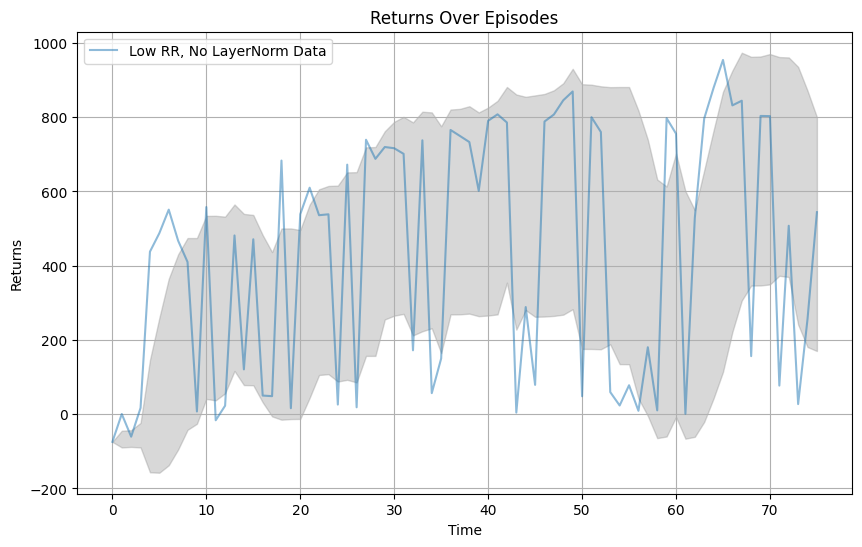

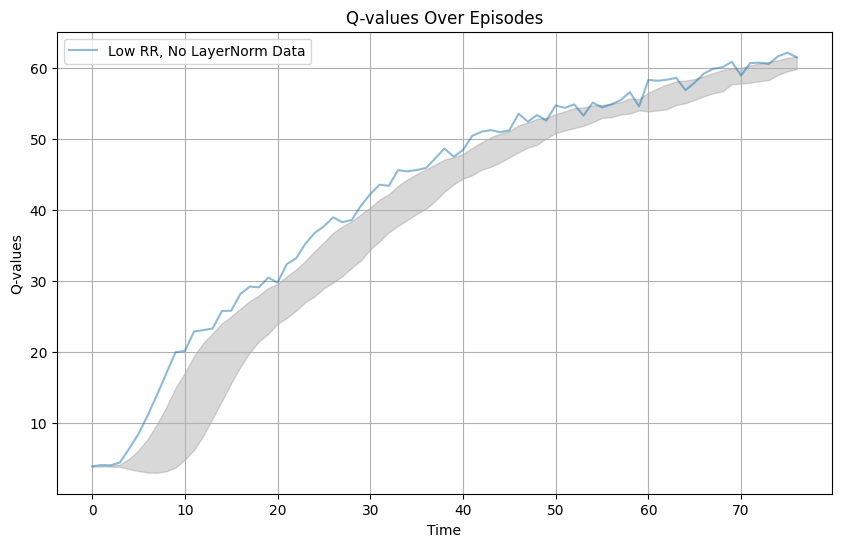

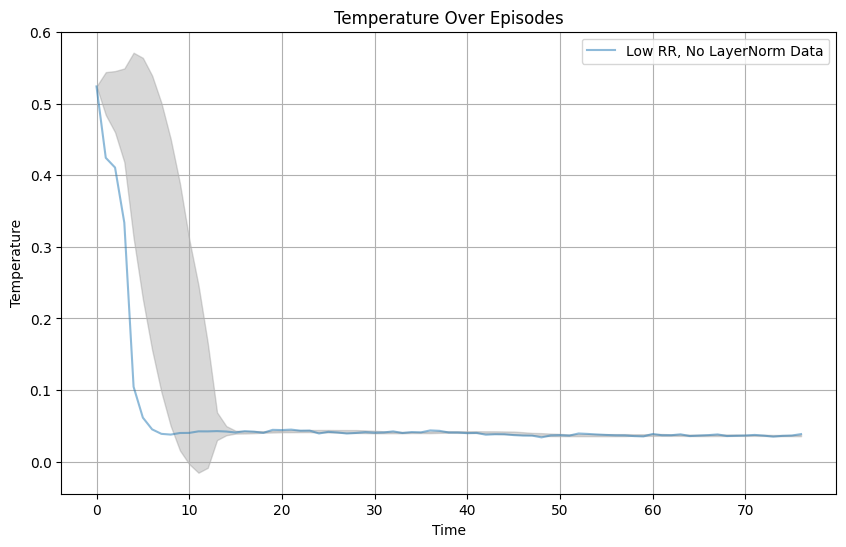

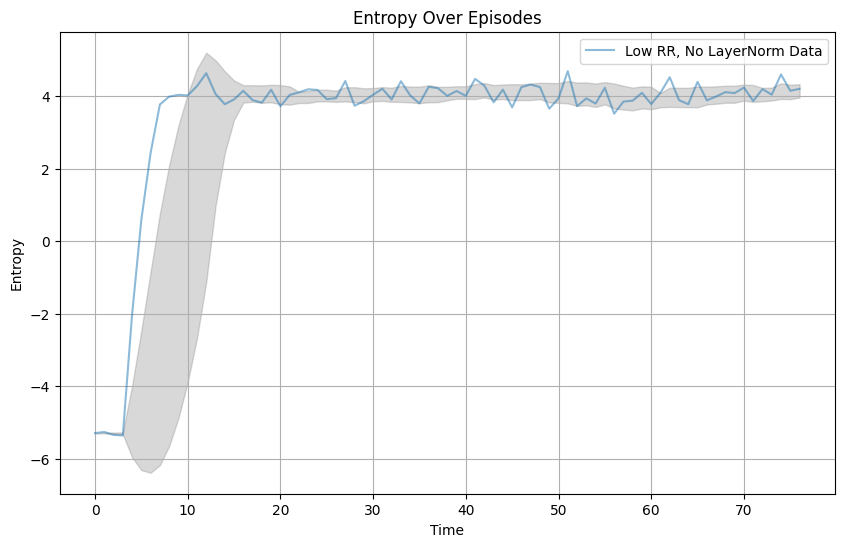

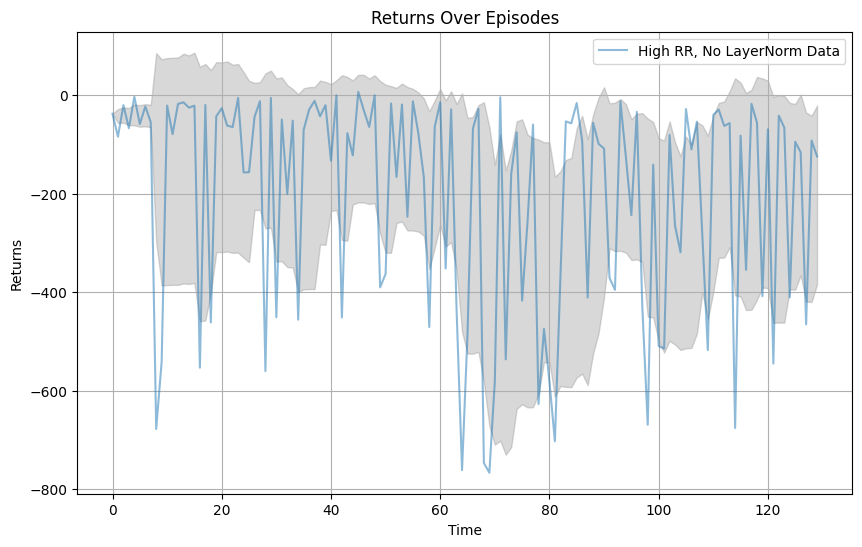

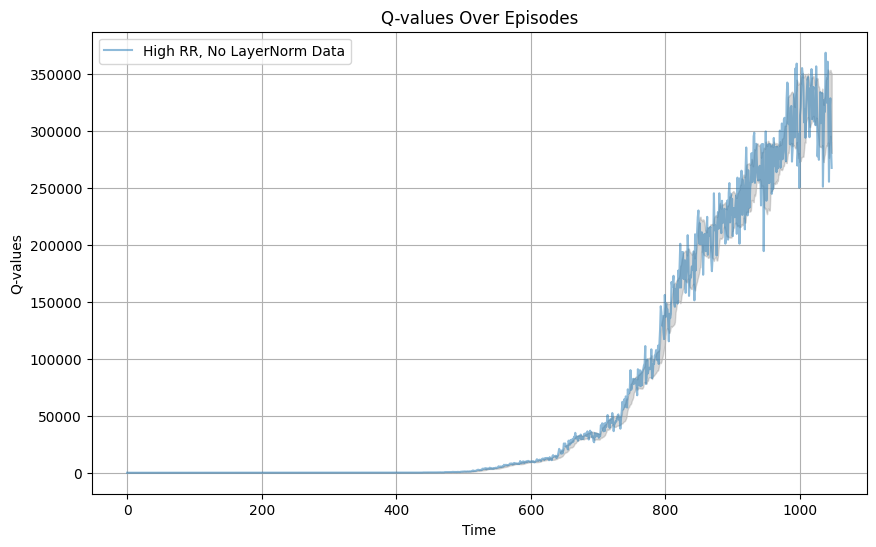

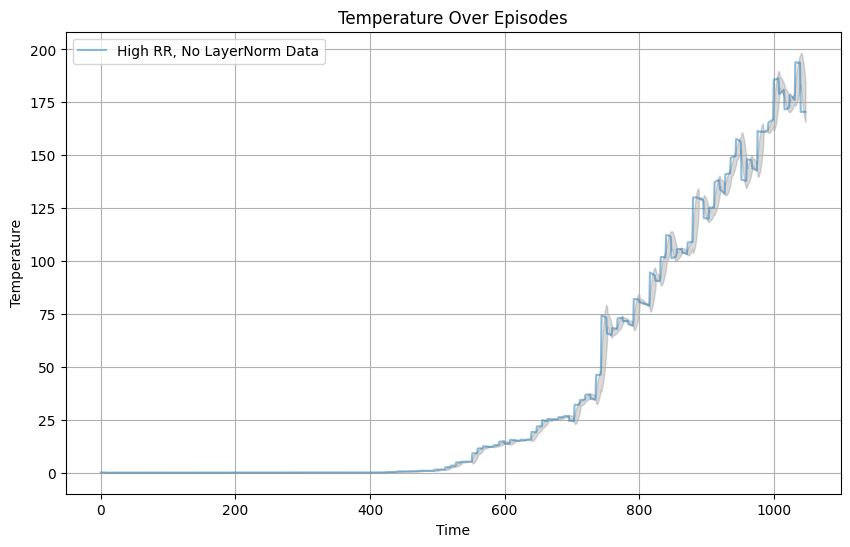

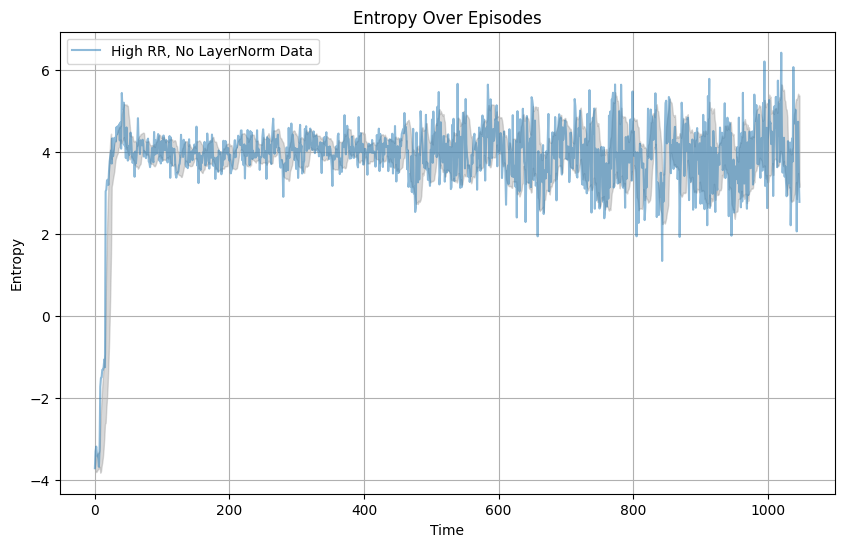

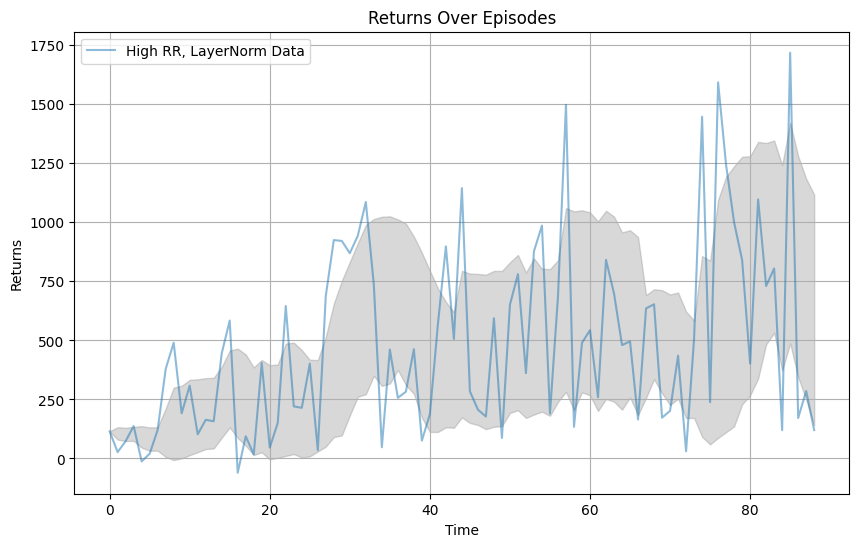

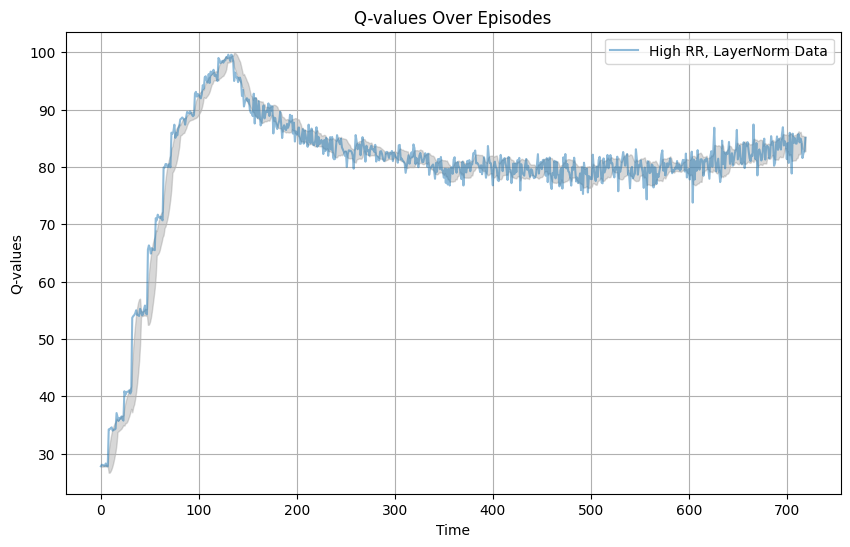

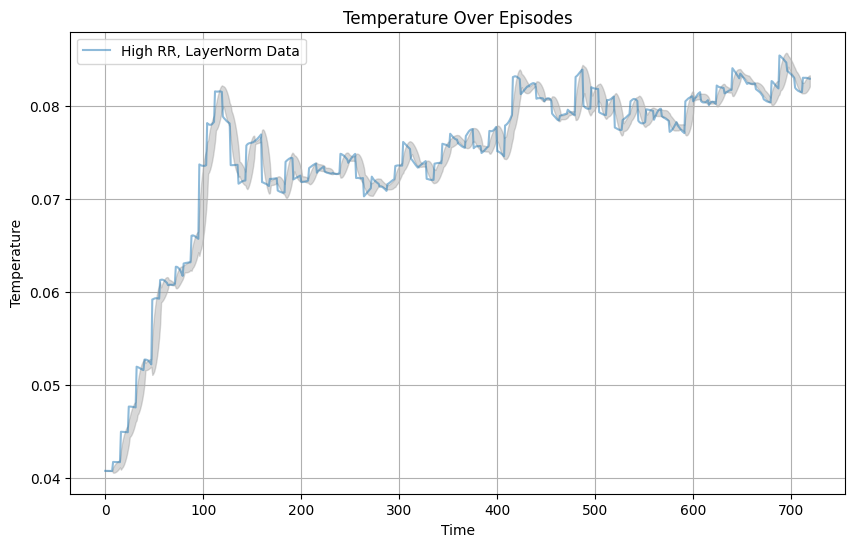

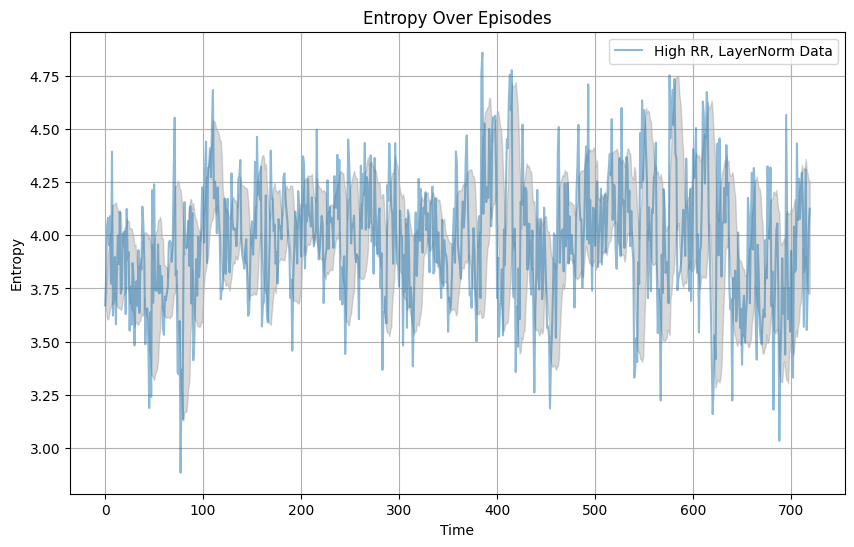

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

history_lowrr = np.load("history_lowrr.npz", allow_pickle=True)['arr_0'].item()
history_noln = np.load("history_noln.npz", allow_pickle=True)['arr_0'].item()
history_ln = np.load("history_ln.npz", allow_pickle=True)['arr_0'].item()

def moving_average(data, window_size=10):
    """Calculate moving average with specified padding at the beginning."""
    padded_data = np.pad(data, (window_size-1, 0), mode='edge')
    cumsum = np.cumsum(np.insert(padded_data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

def moving_std(data, window_size=10):
    """Calculate moving standard deviation with specified padding at the beginning."""
    padded_data = np.pad(data, (window_size-1, 0), mode='edge')
    return np.array([np.std(padded_data[i:i+window_size]) for i in range(len(data))])

def plot_and_save_pdf(pdf, history, label):
    metrics = ['returns', 'q_value', 'temperature', 'entropy']
    titles = ['Returns Over Episodes', 'Q-values Over Episodes', 'Temperature Over Episodes', 'Entropy Over Episodes']
    ylabels = ['Returns', 'Q-values', 'Temperature', 'Entropy']

    for metric, title, ylabel in zip(metrics, titles, ylabels):
        plt.figure(figsize=(10, 6))
        data = np.asarray(history[metric])
        episodes = np.arange(len(data))

        # Compute moving averages and standard deviations
        ma = moving_average(data, window_size=10)
        mstd = moving_std(data, window_size=10)

        plt.plot(episodes, data, label=f"{label} Data", alpha=0.5)  # plotting the original data
        plt.fill_between(episodes, ma - mstd, ma + mstd, color='grey', alpha=0.3)  # std deviation area

        plt.title(f"{title}")
        plt.xlabel('Time')
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        pdf.savefig()
        plt.show()
        plt.close()

with PdfPages('training_histories.pdf') as pdf:
    plot_and_save_pdf(pdf, history_lowrr, 'Low RR, No LayerNorm')
    plot_and_save_pdf(pdf, history_noln, 'High RR, No LayerNorm')
    plot_and_save_pdf(pdf, history_ln, 'High RR, LayerNorm')



## Task 3b (writing)
Investigate the data and describe the issues that you observe. In particular, focus on the contrast between tested model variations in the following contexts:

1. Does the critic learn correct Q-values? Does it overestimate or underestimate?
2. Is the temperature mechanism enough to stabilize the entropy?
3. What happens to the entropy temperature parameter? Why would it take "large" values (ie. > 10)?


# Analysis of SAC Model Performance Across Different Configurations

### 1. Low RR, No LayerNorm
- **Q-values**: There is a logarithmic stable increase, indicating
a learrning process where the values are underestimated but converging to the correct values.
- **Episode Returns**: The returns are highly volatile but there is a clear trend of improvement. This suggests that the critic is learning to effectively capture the value of the policy's decisions.

### 2. High RR, No LayerNorm
- **Q-values**: There is an exponential increase, and the values are extremely high which indicates a clear overestimation.
- **Episode Returns**: It's hard to observe any upward trend, it does not correlate with the high values of Q-values, indicating an extremely overly optimistic critic.

### 3. High RR, LayerNorm
- **Q-values**: Show a steady exponential increase and then a more leveled off pattern. This pattern is a more expected behavior as it suggests learning is stabilizing.
- **Episode Returns**: They show a more consistent upward trend, closely aligning with the Q-values, indicating a more accurate representation of the expected returns.

## Impact of Temperature and Target Entropy

### Entropy and Temperature Observations
- **Low RR, No LayerNorm**: Stable entropy, not much variance about the target value. Temperature converging (decreasing) to a small value close to zero.
- **High RR, No LayerNorm**: Unstable entropy with a lot of variance. The variance increases with time. High temperature suggests an attempt to counteract large Q-values, we can
see how closely positively correlated the plots for Q-values and the temperature are.
- **High RR, LayerNorm**: There is a good amount of variance in the entropy values but the variance seems to be stable through time suggesting a better behaviour compared to **High RR, No LayerNorm**.  Again, we can observe a close positive correlation between the Q-values and the temperature behaviour.

**High RR, No LayerNorm** example shows that the temperature parameter alone isn't enough to stabilize entropy.

The entropy temperature parameter may take large values to counteract an overly optimistic critic, ensuring robust exploration and preventing premature convergence on suboptimal high Q-value estimates.

## Task 3c (writing)
In previous questions we compare sum of episodic rewards to critic output at starting state. Is this approach correct given that our critic learns soft Q-values? What are the problems with this approach?




### Comparing the sum of episodic rewards directly to the critic's output at the starting state where the critic learns soft Q-values, poses some problems and inaccuracies:

* The policy’s explorative behavior, encouraged by high entropy in soft Q-values, might lead to non-optimal immediate rewards as part of a strategy to explore more of the state space. Comparing these results to the episodic sum can undervalue a policy that is effectively exploring and improving over the long term.

* The critic's soft Q-value at the starting state reflects the expected return from that state under the current policy, incorporating all future states until the end of the episode. However, episodic rewards are cumulative and context-specific, depending on the specific trajectory taken by the policy, which may not be fully representative of the expected outcomes the critic is modeling, especially in stochastic environments.

## Task 3d (writing - bonus question)
Why would using layer normalization help with value overestimation in high RR?

### 1. **Stabilizing Training**
- High replay ratios mean that networks often revisit and learn from old experiences in the replay buffer, which can lead to overfitting to particular states and actions. Layer normalization helps mitigate this by keeping the input distributions to each layer stable across training iterations, reducing the risk of overfitting and subsequently, overestimation.

### 2. **Uniform Error Distribution**
- By normalizing the inputs across features, layer normalization ensures that gradients remain on a similar scale across different layers.

### 3. **Enhancing Generalization**
- Layer normalization reduces the covariate shift within the network, enhancing the network’s ability to generalize from training data. This is particularly important in environments with high replay ratios, where the critic must accurately evaluate unseen state-action pairs without being overly optimistic.

### 4. **Reducing Sensitivity to Input Scale**
- Networks without normalization can become overly sensitive to the scale of input features, which can skew value estimates.

### 5. **Improving Convergence Rates**
- Layer normalization can allow for higher learning rates and less sensitive parameter initialization, facilitating faster and more stable convergence.